In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [252]:
df_train = pd.read_csv('twitter_training.csv')
df_val = pd.read_csv('twitter_validation.csv')

# EDA

In [253]:
df_train.head()

2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...

In [254]:
df_train.rename(columns = {'2401':'Tweet_code',
                    'Borderlands': 'Source', 
                    'Positive':'Sentiment',
                    'im getting on borderlands and i will murder you all ,': 'core-text'}, 
            inplace = True)
    

In [255]:
df_train.head()

Tweet_code       Source Sentiment  \
0        2401  Borderlands  Positive   
1        2401  Borderlands  Positive   
2        2401  Borderlands  Positive   
3        2401  Borderlands  Positive   
4        2401  Borderlands  Positive   

                                           core-text  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...

In [256]:
df_train.shape

(74681, 4)

In [257]:
d1= df_train.value_counts('Sentiment')

In [258]:
#Counting the number of missing values of the dataset
df_train.isnull().sum()

Tweet_code      0
Source          0
Sentiment       0
core-text     686
dtype: int64

In [259]:
# Replacing the missing values with null strings
df_train= df_train.fillna('')

In [260]:
df_train.isnull().sum()

Tweet_code    0
Source        0
Sentiment     0
core-text     0
dtype: int64

In [261]:
#Counting duplicates:
df_train.duplicated().sum()

2700

In [262]:
#To drop duplicates:
df_train= df_train.drop_duplicates()

In [263]:
#Data type:
df_train.dtypes

Tweet_code     int64
Source        object
Sentiment     object
core-text     object
dtype: object

In [264]:
#Dropping the Tweet_code column 
df_train= df_train.drop('Tweet_code',axis=1)

In [328]:
df_train= df_train.replace({'Irrelevant':'neutral','Neutral':'neutral', 'Positive':'positive','Negative':'negative'})

In [329]:
#Validation set, dropping the code column:
#df_val= df_val.drop('3364', axis=1)
df_val.head()

3364     Source Sentiment  \
0   352     Amazon   Neutral   
1  8312  Microsoft  Negative   
2  4371      CS-GO  Negative   
3  4433     Google   Neutral   
4  6273       FIFA  Negative   

                                           core-text  \
0  BBC News - Amazon boss Jeff Bezos rejects clai...   
1  @Microsoft Why do I pay for WORD when it funct...   
2  CSGO matchmaking is so full of closet hacking,...   
3  Now the President is slapping Americans in the...   
4  Hi @EAHelp I‚Äôve had Madeleine McCann in my cel...   

                                             content  
0  amazon news - amazon bos jeff bezo reject clai...  
1  microsoft; @microsoft pay word function poorli...  
2  cs-go; csgo matchmak full closet hacking, trul...  
3  googl presid slap american face realli commit ...  
4  fifa; hi @eahelp i‚Äôv madelein mccann cellar pa...

In [267]:
# Replacing the missing values with null strings
df_val= df_val.fillna('')
#To drop duplicates:
df_val= df_val.drop_duplicates()
#Rename columns:
df_val.rename(columns = {
                    'Facebook': 'Source', 
                    'Irrelevant':'Sentiment',
                    'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom‚Äôs great auntie as ‚ÄòHayley can‚Äôt get out of bed‚Äô and told to his grandma, who now thinks I‚Äôm a lazy, terrible person ü§£': 'core-text'}, 
            inplace = True)

In [330]:
df_val= df_val.replace({'Irrelevant':'neutral','Neutral':'neutral', 'Positive':'positive','Negative':'negative'})
df_val.head()

3364     Source Sentiment  \
0   352     Amazon   neutral   
1  8312  Microsoft  negative   
2  4371      CS-GO  negative   
3  4433     Google   neutral   
4  6273       FIFA  negative   

                                           core-text  \
0  BBC News - Amazon boss Jeff Bezos rejects clai...   
1  @Microsoft Why do I pay for WORD when it funct...   
2  CSGO matchmaking is so full of closet hacking,...   
3  Now the President is slapping Americans in the...   
4  Hi @EAHelp I‚Äôve had Madeleine McCann in my cel...   

                                             content  
0  amazon news - amazon bos jeff bezo reject clai...  
1  microsoft; @microsoft pay word function poorli...  
2  cs-go; csgo matchmak full closet hacking, trul...  
3  googl presid slap american face realli commit ...  
4  fifa; hi @eahelp i‚Äôv madelein mccann cellar pa...

<AxesSubplot: xlabel='Sentiment', ylabel='count'>

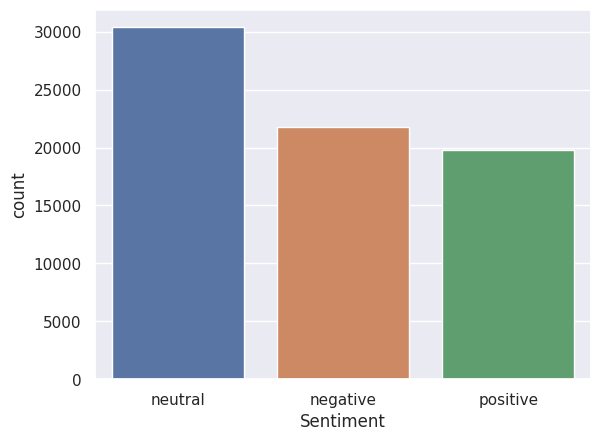

In [331]:
sns.set(style='darkgrid')
sns.countplot(data= df_train, x='Sentiment', order = df_train['Sentiment'].value_counts().index)

<AxesSubplot: ylabel='Source'>

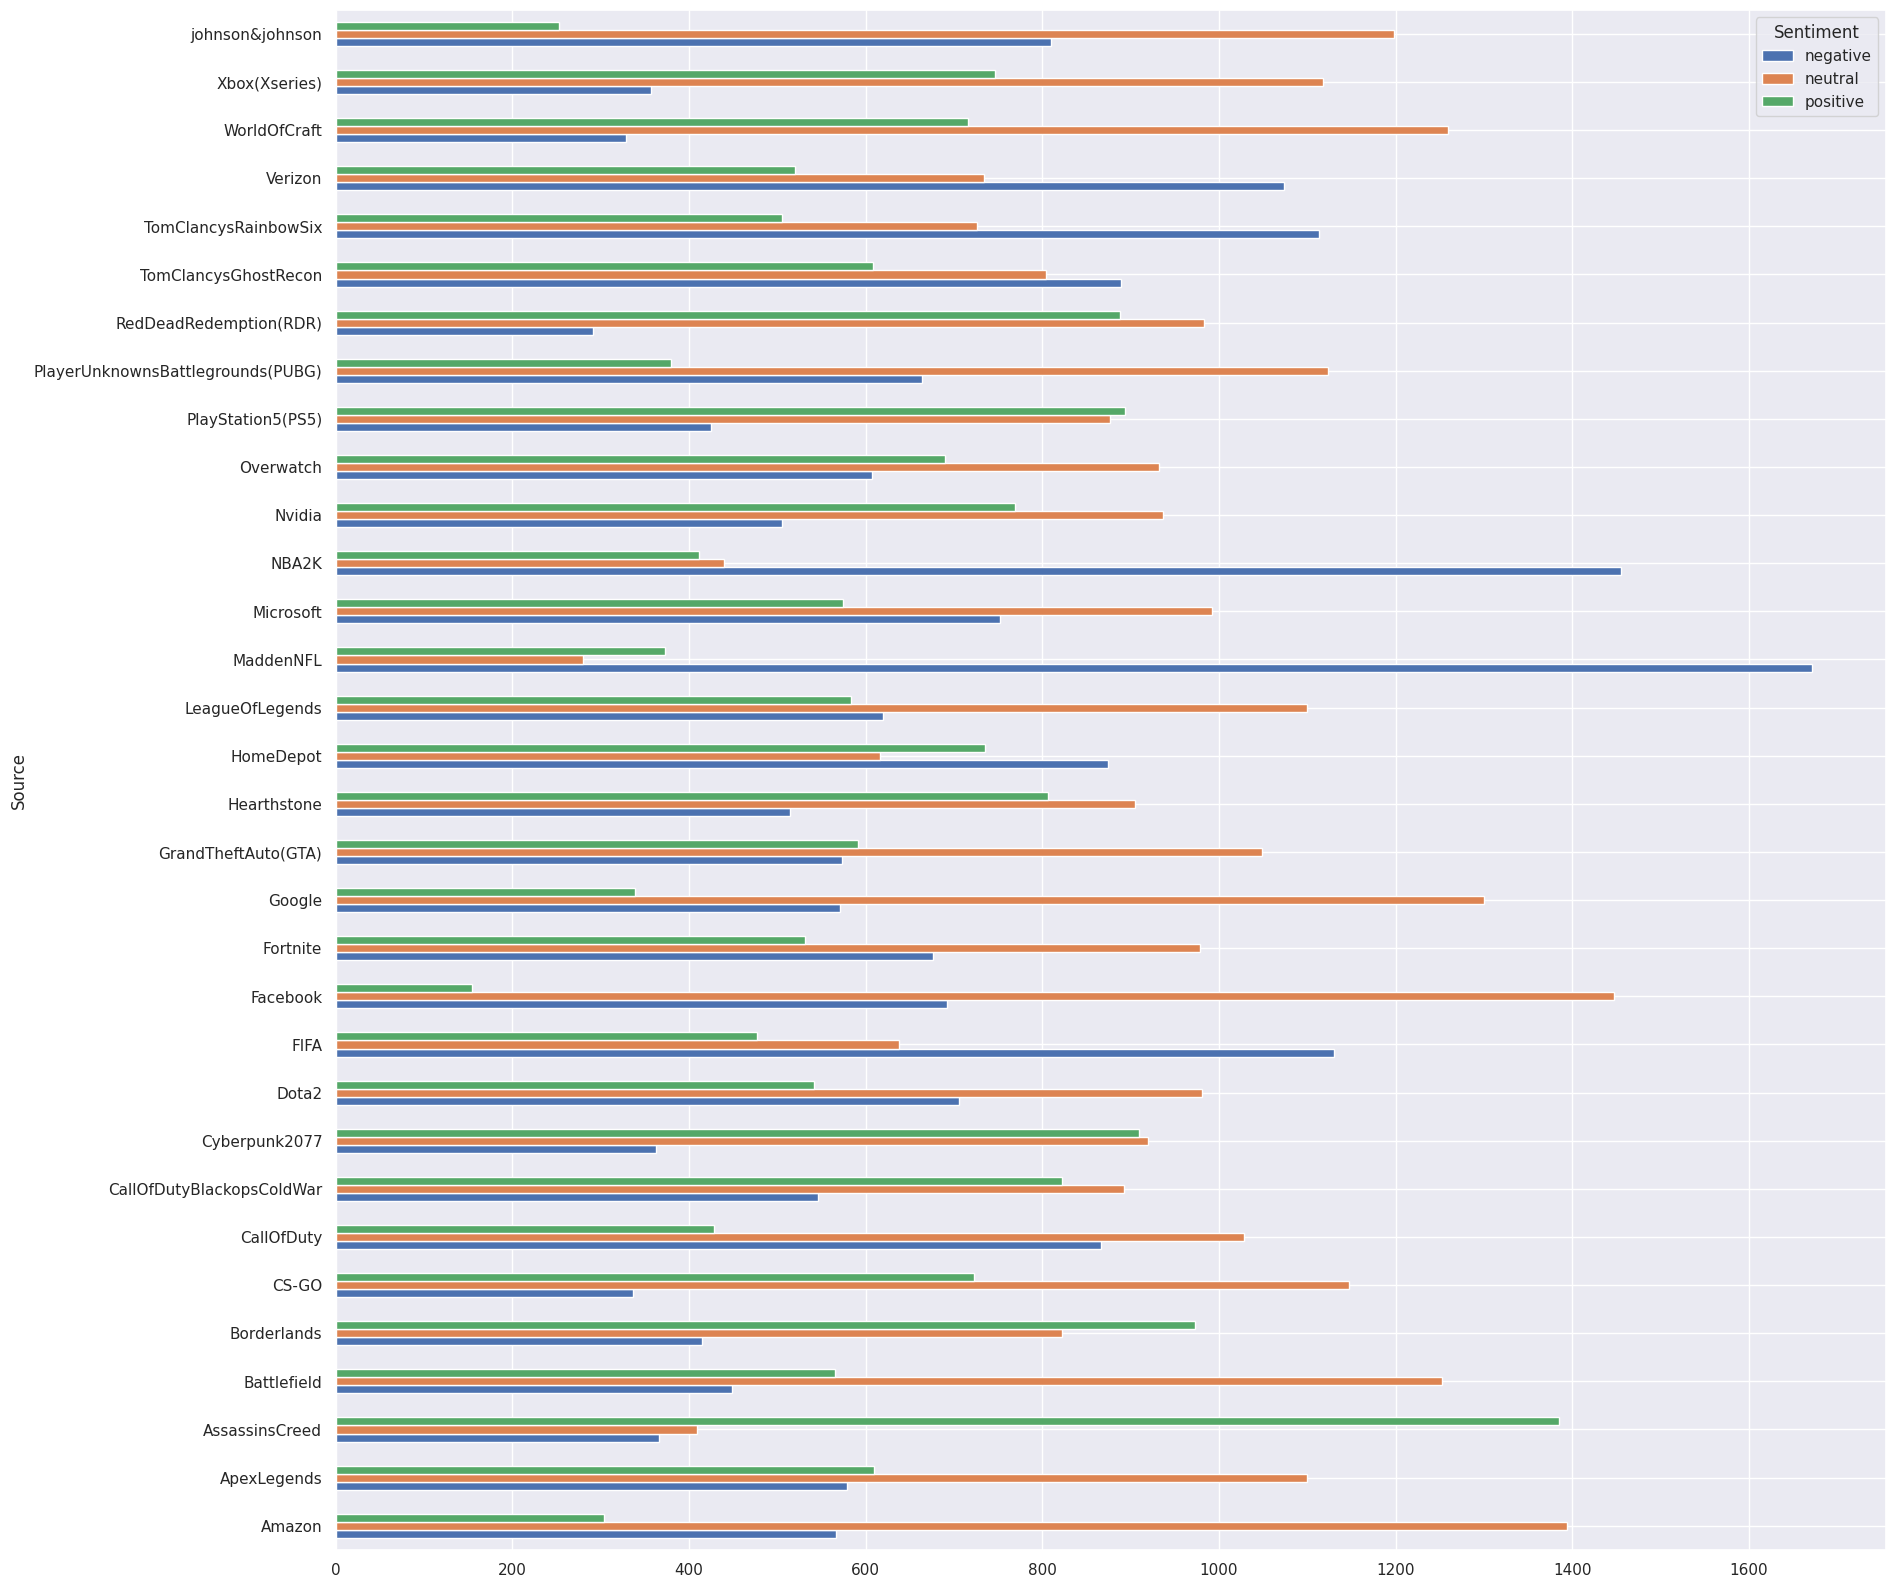

In [332]:
sent_by_source = df_train.groupby(['Source', 'Sentiment']).Sentiment.count().unstack()
sent_by_source.plot(kind='barh',figsize=(20,20))

In [333]:
#TRAINING SET:  Merging the Tweet_code, Source and core-text columns
df_train['content']= df_train['Source'] + '; ' + df_train['core-text']
df_train.dtypes

Source       object
Sentiment    object
core-text    object
content      object
dtype: object

In [272]:
# Dropping the columns:
#df_train= df_train.drop(['Source','core-text'], axis=1)

In [334]:
#VALIDATION SET:  Merging the Tweet_code, Source and core-text columns
df_val['content']= df_val['Source'] + '; ' + df_val['core-text']
df_val.dtypes

# Dropping the columns:
#df_val= df_val.drop(['Source','core-text'], axis=1)

3364          int64
Source       object
Sentiment    object
core-text    object
content      object
dtype: object

# Cleaning Data

In [335]:
#TRAINING SET: 
X = df_train.drop('Sentiment',axis=1)
y = df_train['Sentiment']

In [336]:
print('X values are: ', X)
print('Y values are: ', y)

X values are:              Source                                          core-text  \
0      Borderlands  I am coming to the borders and I will kill you...   
1      Borderlands  im getting on borderlands and i will kill you ...   
2      Borderlands  im coming on borderlands and i will murder you...   
3      Borderlands  im getting on borderlands 2 and i will murder ...   
4      Borderlands  im getting into borderlands and i can murder y...   
...            ...                                                ...   
74676       Nvidia  Just realized that the Windows partition of my...   
74677       Nvidia  Just realized that my Mac window partition is ...   
74678       Nvidia  Just realized the windows partition of my Mac ...   
74679       Nvidia  Just realized between the windows partition of...   
74680       Nvidia  Just like the windows partition of my Mac is l...   

                                                 content  
0      Borderlands; I am coming to the borders an

In [337]:
#VALIDATION SET: 
X_val = df_val.drop('Sentiment',axis=1)
y_val = df_val['Sentiment']
print('X_validation set values are: ', X_val)
print('y_validation set values are: ', y_val)

X_validation set values are:       3364               Source  \
0     352               Amazon   
1    8312            Microsoft   
2    4371                CS-GO   
3    4433               Google   
4    6273                 FIFA   
..    ...                  ...   
994  4891  GrandTheftAuto(GTA)   
995  4359                CS-GO   
996  2652          Borderlands   
997  8069            Microsoft   
998  6960      johnson&johnson   

                                             core-text  \
0    BBC News - Amazon boss Jeff Bezos rejects clai...   
1    @Microsoft Why do I pay for WORD when it funct...   
2    CSGO matchmaking is so full of closet hacking,...   
3    Now the President is slapping Americans in the...   
4    Hi @EAHelp I‚Äôve had Madeleine McCann in my cel...   
..                                                 ...   
994  ‚≠êÔ∏è Toronto is the arts and culture capital of ...   
995  tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...   
996  Today sucked so it‚Äôs time 

### Stemming Process: 
Stemming is the process of reducing  words into their root-word.

In [338]:
import nltk
# Downloading stop words
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('omw-1.4')
  

[nltk_data] Downloading package stopwords to /home/yesica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yesica/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/yesica/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [339]:
port_stem = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [340]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ' ,content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = [lemmatizer.lemmatize(word) for word in stemmed_content if not word in stopwords.words('english')]

    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

Stemming function: once I give it an input value (text):

- In the first step the function sub returns us, in this case, everything from a-z or A-Z that is to say, it excludes everything that is not alphabet. If it finds a digit or special character it will replace ir by an empty space.
- Secondly, to convert all letter into lowercase because some ML models use to have some problems with uppercases.
- After that, we split the words and create a list.
- Finally, the function will do the stemming process but it will remove all the stopwords and then it will join all the results words again

In [341]:
#TRAINING SET: 
df_train['content'] = df_train['content'].apply(stemming)
print(df_train['content'])

0                              borderland come border kill
1                        borderland im get borderland kill
2                     borderland im come borderland murder
3                      borderland im get borderland murder
4                      borderland im get borderland murder
                               ...                        
74676    nvidia realiz window partit mac like year behi...
74677    nvidia realiz mac window partit year behind nv...
74678    nvidia realiz window partit mac year behind nv...
74679    nvidia realiz window partit mac like year behi...
74680    nvidia like window partit mac like year behind...
Name: content, Length: 71981, dtype: object


In [342]:
# Let's convert the columns into arrays for our train set
X = df_train['content'].values
y= df_train['Sentiment'].values

print(X)
print(y)


['borderland come border kill' 'borderland im get borderland kill'
 'borderland im come borderland murder' ...
 'nvidia realiz window partit mac year behind nvidia driver idea notic'
 'nvidia realiz window partit mac like year behind nvidia driver car fuck idea ever notic'
 'nvidia like window partit mac like year behind driver idea notic']
['positive' 'positive' 'positive' ... 'positive' 'positive' 'positive']


In [343]:
#VALIDATION SET: 
df_val['content'] = df_val['content'].apply(stemming)
print(df_val['content'])

0      amazon bbc news amazon bos jeff bezo reject cl...
1      microsoft microsoft pay word function poorli s...
2      c go csgo matchmak full closet hack truli aw game
3      googl presid slap american face realli commit ...
4      fifa hi eahelp madelein mccann cellar past yea...
                             ...                        
994    grandtheftauto gta toronto art cultur capit ca...
995    c go actual good move tot bring viewer one peo...
996    borderland today suck time drink wine n play b...
997    microsoft bought fraction microsoft today smal...
998    johnson johnson johnson johnson stop sell talc...
Name: content, Length: 999, dtype: object


In [344]:
# Let's convert the columns into arrays for our TESTING set
X_val = df_val['content'].values
y_val= df_val['Sentiment'].values

print('The shape of X test is: ', X_val.shape)
print('The shape of y test is: ', y_val.shape)

The shape of X test is:  (999,)
The shape of y test is:  (999,)


# Creating Visualization of the Data set

In [347]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white')
from nltk import FreqDist #function to find the frequent words in the data

# Subset positive review dataset
positive_words_df = df_train.loc[df_train['Sentiment'] == 'Positive',:]

#Extracts words into list and count frequency
all_words = ' '.join([text for text in positive_words_df['content']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 20) 

words_df.sort_values('count', inplace = True)



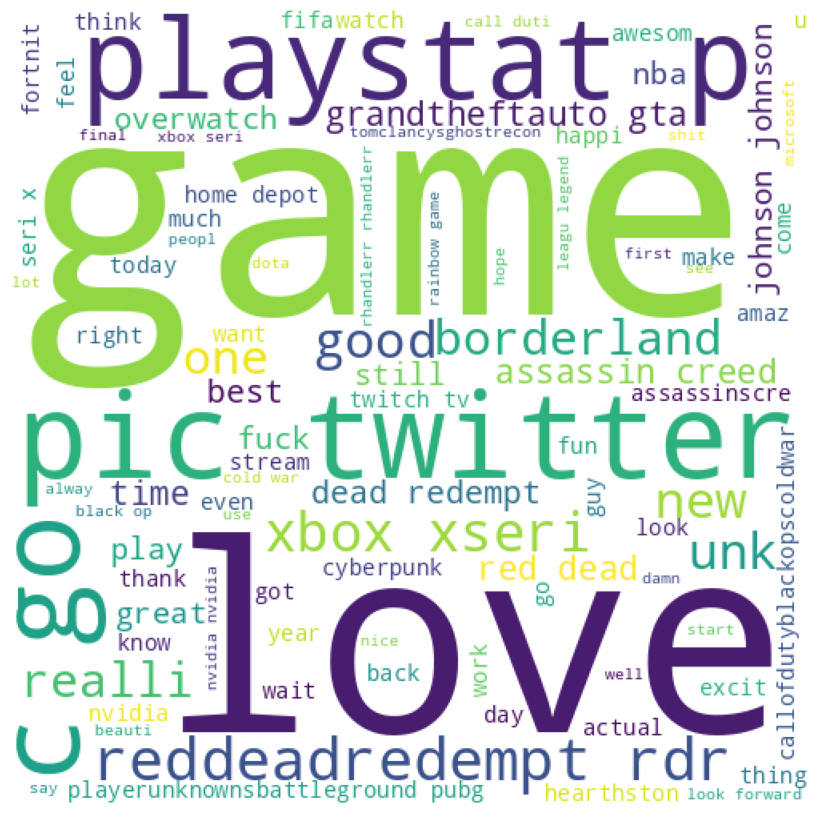

In [349]:
from wordcloud import WordCloud
word_cloud_df = df_train.loc[df_train['Sentiment'] == 'positive',:]
all_words = ' '.join([text for text in word_cloud_df['content']])
 

wordcloud = WordCloud(width = 500, height = 500, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### TfidfVectorizer: 

The method addresses the fact that all words should not be weighted equally, using the weights to indicate the words that are most unique to the document, and best used to characterize it.

In [350]:
# We have to convert all the text into some numerical singificant values to could fit our ML model. To do that, we are going to use 
# TfidfVectorizer

vectorizer = TfidfVectorizer()
X= vectorizer.fit_transform(X)
X_val=vectorizer.transform(X_val)

In [351]:
#Split our train and test sets.
X_train= X
X_test = X_val
y_train= y
y_test= y_val

In [352]:
print(X_train)
print(y_train)

  (0, 10293)	0.45814430553293767
  (0, 2113)	0.6859466925150894
  (0, 3444)	0.41071531799461913
  (0, 2115)	0.3884505861752953
  (1, 7309)	0.2944676912777425
  (1, 9047)	0.4605211665211116
  (1, 10293)	0.4253582267900245
  (1, 2115)	0.7213039670497016
  (2, 12491)	0.5469019409909265
  (2, 9047)	0.4115167740574005
  (2, 3444)	0.3407464899514244
  (2, 2115)	0.6445494870027678
  (3, 12491)	0.5601872129595947
  (3, 7309)	0.26952516725037284
  (3, 9047)	0.4215132868748825
  (3, 2115)	0.6602068006641202
  (4, 12491)	0.5601872129595947
  (4, 7309)	0.26952516725037284
  (4, 9047)	0.4215132868748825
  (4, 2115)	0.6602068006641202
  (5, 9756)	0.2449624108085843
  (5, 21077)	0.28342578809573316
  (5, 12167)	0.28342578809573316
  (5, 3435)	0.08172231726434458
  (5, 19757)	0.10635323645301857
  :	:
  (71978, 21818)	0.19296702390728418
  (71979, 13930)	0.4046266326404539
  (71979, 13182)	0.3532780078679542
  (71979, 5107)	0.2747922041845038
  (71979, 21222)	0.25926404003192727
  (71979, 2669)	0.2617

In [353]:
# machine learning - Random Forest Classifier's resources

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [362]:
#Function to fit and apply a model
def model_apply(model):
    #train the model
    model.fit(X_train,y_train)
    #make predictions
    predictions=model.predict(X_test)
    #model evaluation
    print(model)
    print('Accuracy score: ',accuracy_score(y_test, predictions))
    print('Weighted F1 score: ',classification_report(y_test, predictions))
    print('Confusion Matrix: \n',confusion_matrix(y_test, predictions))

In [363]:
#Multinomail Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb=MultinomialNB()
model_apply(nb)

MultinomialNB()
Accuracy score:  0.8268268268268268
Weighted F1 score:                precision    recall  f1-score   support

    negative       0.80      0.83      0.81       266
     neutral       0.83      0.87      0.85       456
    positive       0.86      0.75      0.80       277

    accuracy                           0.83       999
   macro avg       0.83      0.82      0.82       999
weighted avg       0.83      0.83      0.83       999

Confusion Matrix: 
 [[222  33  11]
 [ 36 396  24]
 [ 21  48 208]]


In [365]:
#Decision Tree
dtc=DecisionTreeClassifier(random_state=10)
model_apply(dtc)

DecisionTreeClassifier(random_state=10)
Accuracy score:  0.9269269269269269
Weighted F1 score:                precision    recall  f1-score   support

    negative       0.90      0.96      0.93       266
     neutral       0.95      0.92      0.94       456
    positive       0.91      0.91      0.91       277

    accuracy                           0.93       999
   macro avg       0.92      0.93      0.93       999
weighted avg       0.93      0.93      0.93       999

Confusion Matrix: 
 [[256   5   5]
 [ 17 418  21]
 [ 10  15 252]]


In [366]:
#Random Forest
rf=RandomForestClassifier(random_state=101,n_jobs=-1)
model_apply(rf)

RandomForestClassifier(n_jobs=-1, random_state=101)
Accuracy score:  0.95995995995996
Weighted F1 score:                precision    recall  f1-score   support

    negative       0.97      0.96      0.97       266
     neutral       0.95      0.97      0.96       456
    positive       0.96      0.94      0.95       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999

Confusion Matrix: 
 [[256   7   3]
 [  7 442   7]
 [  1  15 261]]


In [384]:
new_value= X_train[1]
new_value.shape

print(rf.predict(new_value))




['positive']


In [385]:

y_train[1]

'positive'